In [1]:
# only execute this cell when running in colab environment
COLAB = True

# check if gpu is enabled
!nvidia-smi

from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/dne /dne
!ls -ahl /dne
!rm -rf /dne/checkout
!git clone https://github.com/avhou/dne.git /dne/checkout
!ls -ahl /dne/checkout/code
import sys
sys.path.append('/dne/checkout/code')

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'google'

In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader,TensorDataset
import building_blocks
from building_blocks import *

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
data = pd.read_csv('https://raw.githubusercontent.com/avhou/dne/main/code/data/electricity.csv')
data.drop("Meter ID", axis=1, inplace=True)
# keep only a small subset
data = data.iloc[:64*5]
TARGET_COL = 'total daily KW'

cpu


In [63]:
SEQUENCE_SIZE = 30
BATCH_SIZE = 64
train = data.iloc[:int(data.shape[0]*0.7)][TARGET_COL].to_numpy().reshape(-1, 1)
val = data.iloc[int(data.shape[0]*0.7):int(data.shape[0]*0.8)][TARGET_COL].to_numpy().reshape(-1, 1)
test =  data.iloc[int(data.shape[0]*0.8):][TARGET_COL].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train).flatten().tolist()
scaled_val = scaler.fit_transform(val).flatten().tolist()
scaled_test = scaler.transform(test).flatten().tolist()

x_train, y_train = to_sequences(SEQUENCE_SIZE, scaled_train)
x_val, y_val = to_sequences(SEQUENCE_SIZE, scaled_val)
x_test, y_test = to_sequences(SEQUENCE_SIZE, scaled_test)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [64]:
INPUT_DIM= SEQUENCE_SIZE
EMBED_SIZE= 512
NUM_LAYERS= 4
HEADS= 8
FORWARD_EXPANSION= 512
DROPOUT= 0.2
FORECAST_SIZE= 1

# https://stackoverflow.com/questions/65996797/how-to-refresh-a-python-import-in-a-jupyter-notebook-cell
from importlib import reload
reload(building_blocks)
from building_blocks import *

model_params = TimeSeriesTransformerParams(
    input_dim=INPUT_DIM,
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    heads=HEADS,
    device=device,
    forward_expansion=FORWARD_EXPANSION,
    dropout=DROPOUT,
    forecast_size=FORECAST_SIZE
)
scenario_params = ScenarioParams(
    name="electricity",
    device=device,
    epochs=100,
    dataloader_train=train_loader,
    dataloader_validation=val_loader,
    dataloader_test=test_loader,
    base_path="/dne" if 'COLAB' in locals() and COLAB else "./",
    early_stop_count=5
)
model = TimeSeriesTransformer.from_params(model_params).to(device)
scenario = Scenario(scenario_params)
result = scenario.execute(model)
print(f"execution done")

/Users/alexander/ou/IM1102 - Deep Neural Engineering/github/code/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


checking paths, base path is ./
training and validating the model
New best training score at epoch 1
New best validation score at epoch 1
increasing early stop count
Epoch 1/100, Training Loss: 1.3144, Validation Loss: 0.1248
New best validation score at epoch 2
increasing early stop count
Epoch 2/100, Training Loss: 1.4413, Validation Loss: 0.0944
increasing early stop count
Epoch 3/100, Training Loss: 1.5608, Validation Loss: 0.0944
increasing early stop count
Epoch 4/100, Training Loss: 1.9791, Validation Loss: 0.1248
increasing early stop count
Early stopping!
Best val model saved to file ./weights/electricity_model_best_val.pth from epoch 2
testing the model
saving all losses to disk
execution done


Text(0.5, 1.0, 'Test loss')

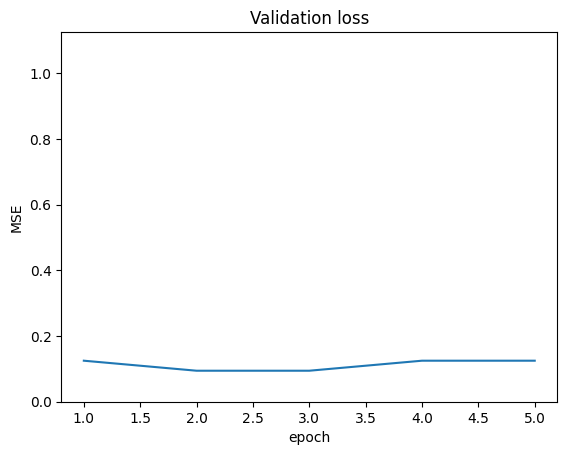

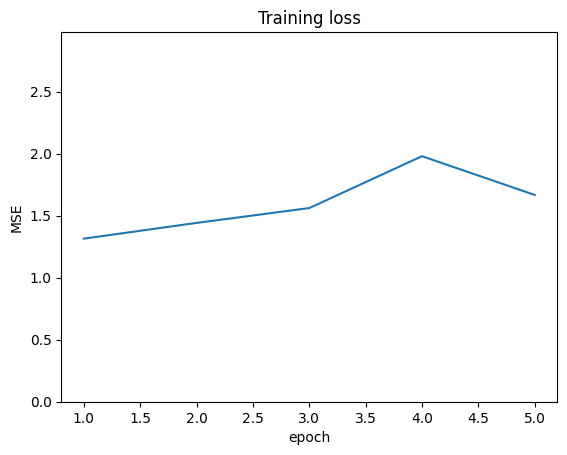

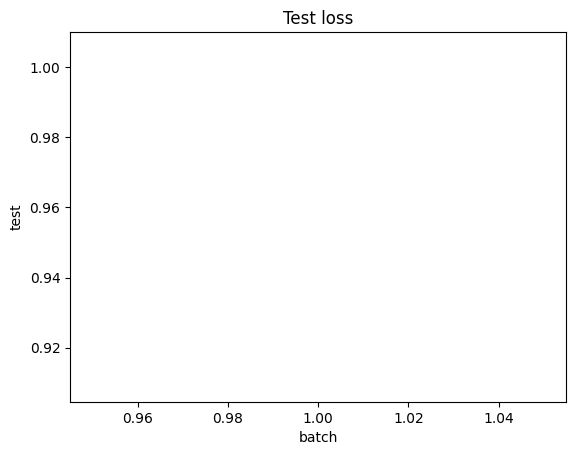

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_pickle('./weights/electricity_train_val_losses.pkl')
data['epoch'] = pd.Series([int(x) + 1 for x in range(len(data))])
fig, ax = plt.subplots()
g = sns.lineplot(ax = ax, data=data, x='epoch', y='validation')
g.set_title(f"Validation loss")
g.set_ylabel("MSE")
g.set_ylim([0, np.max(data['validation']) + 1])
fig, ax = plt.subplots()
g = sns.lineplot(ax = ax, data=data, x='epoch', y='training')
g.set_title(f"Training loss")
g.set_ylabel("MSE")
g.set_ylim([0, np.max(data['training']) + 1])

data = pd.read_pickle('./weights/electricity_test_losses.pkl')
data['batch'] = pd.Series([int(x) + 1 for x in range(len(data))])
fig, ax = plt.subplots()
g = sns.lineplot(ax = ax, data=data, x='batch', y='test')
g.set_title(f"Test loss")